MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

VALUES
- N = 2
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 1.2975 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ 1.2500 * 2 * pi (Omega = 0.3)
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 5.342 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
- N = 3
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
import os
import shutil
import time
from datetime import datetime
from glob import glob
from copy import copy
from supports import *
from scan import sample
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

options = Options()
options.store_states=True

In [17]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1

wq = 6.5 *2*pi     # qubit frequency
wc = 4 *2*pi       # resonator frequency
delta = wq - wc    # detuning
Ec = 0.16 *2*pi    # anharmonicity (charging energy)
g = 0.2 *2*pi      # coupling between qubit and resonator
chi = 30e-6 *2*pi  # photon number-dependent frequency shift of qubit

Omega = 0.3 *2 *2*pi  # amplitude of sideband transitions
wd = 5.342*2*pi      # pump drive frequency

wq_mod = wq + Omega**2/(2*(wq-wd)) + Omega**2/(2*(wq+wd))

In [18]:
t0 = 0         # start of simulation
t1 = t0 + 0   # start of drive
t2 = t1 + 250  # end of drive
t3 = t2 + 0   # end of simulation
tg = 10        # length of gaussian rise and fall

smooth = True  # whether or not to rise and fall with gaussian
Q = 3          # number of std's in gaussian rise and fall

Np = 100*int(t3)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(t3/Np, 5), "ps")

timestep = 10.0 ps


In [19]:
# Qubit operators
b = tensor(destroy(Nq), qeye(Nc))
nq = b.dag()*b

# Cavity operators
a = tensor(qeye(Nq), destroy(Nc))
nc = a.dag()*a

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b - chi*nq*nc
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())

# Sideband transitions
Hd = Omega*(b + b.dag())

# Hamiltonian arguments
H_args = {'t0' : t0, 't1' : t1, 't2' : t2,
          't3' : t3, 'tg' : tg, 'Q'  : Q,
          'smooth' : smooth, 'wd' : wd}

# Expectation operators
e_ops = [nq, nc]

In [20]:
H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
psi0 = tensor(psi_0pi(Nq), basis(Nc, 0))  # initial state

# Select these options for bdf method
options.method = 'bdf'
options.rtol = 1e-10
options.atol = 1e-10

# Select these options for adams method
# options.nsteps = 1000
# options.rtol = 1e-12
# options.atol = 1e-12
# options.max_step = 0

Np_per_batch = Np/20  # number of time points per batch

In [21]:
batches = create_batches(0, t3, Np, Np_per_batch)

# Remove existing progress folder
for folder in glob("/home/student/thesis/prog_*"):
    shutil.rmtree(folder)

# Make new progress folder
now = datetime.now()
nowstr = now.strftime("%y_%m_%d_%H_%M_%S")
folder = "/home/student/thesis/prog_" + nowstr
os.makedirs(folder)

# Calculate!
for num, tlist in enumerate(batches):
    print(num+1, "/", len(batches), ":", int(np.round(100*(num+1)/len(batches))), "%")
    result = mesolve(H, psi0, tlist, c_ops=[], e_ops=e_ops, args=H_args, options=options)
    e0, g1, e1, g0 = combined_probs(result.states, Nc)
    saveprog(result, e0, g1, e1, g0, num, folder)
    psi0 = copy(result.states[-1])
    del result, e0, g1, e1, g0
end_calc = datetime.now()
print("Evolution completed in {} s".format((end_calc - now).total_seconds()))

1 / 20 : 5 %
2 / 20 : 10 %
3 / 20 : 15 %
4 / 20 : 20 %
5 / 20 : 25 %
6 / 20 : 30 %
7 / 20 : 35 %
8 / 20 : 40 %
9 / 20 : 45 %
10 / 20 : 50 %
11 / 20 : 55 %
12 / 20 : 60 %
13 / 20 : 65 %
14 / 20 : 70 %
15 / 20 : 75 %
16 / 20 : 80 %
17 / 20 : 85 %
18 / 20 : 90 %
19 / 20 : 95 %
20 / 20 : 100 %
Evolution completed in 114.597597 s


In [22]:
srcfolder = folder # "/home/student/thesis/"
selection = All # (0, t3)
reduction = 5
quants = ['times', 'expect', 'e0', 'g1']

start_comb = datetime.now()
combine_batches(srcfolder, selection, reduction,
                quants=quants, return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0 = load_data(quants, srcfolder)

Batches combined    in 1.525833 s


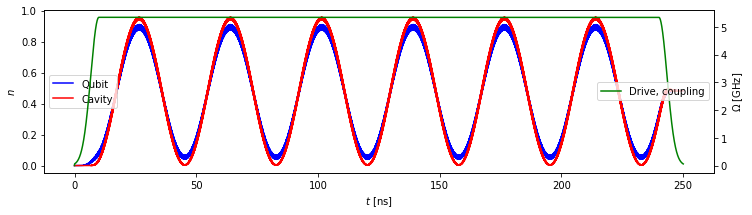

In [23]:
"""EXPECTATION VALUES"""

fig, ax1 = plt.subplots(figsize=[12,3])
ax1.plot(times, expect[0], color='b', label='Qubit')
ax1.plot(times, expect[1], color='r', label='Cavity')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$n$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([20, 21])

drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

plt.show()

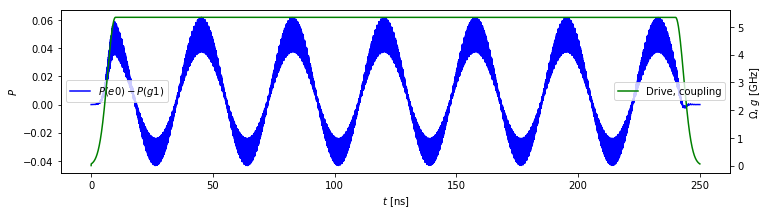

In [27]:
"""COMBINED PROBABILITIES"""

fig, ax1 = plt.subplots(figsize=[12,3])
ax1.plot(times, e0-g1, color='b', label='$P(e0) - P(g1)$')
# ax1.plot(times, e1-g0, color='r', label='$P(e1) - P(g0)$')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$P$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([0, 5])

drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$, $g$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

plt.show()

In [16]:
"""SCANNING"""
# wds = np.linspace(5.34*2*pi, 5.35*2*pi, 11)
# for wd in wds:
#     sample(Nq, wq, wc, wd, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)

'SCANNING'